In [1]:
# checking for tensorflow devices
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
    print(d.name, d.physical_device_desc)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/device:CPU:0 
/device:GPU:0 device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:17.0, compute capability: 7.0
/device:GPU:1 device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:18.0, compute capability: 7.0
/device:GPU:2 device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:19.0, compute capability: 7.0
/device:GPU:3 device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1a.0, compute capability: 7.0
/device:GPU:4 device: 4, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/device:GPU:5 device: 5, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/device:GPU:6 device: 6, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/device:GPU:7 device: 7, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0


In [2]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D
from keras.layers import LSTM
from keras.datasets import imdb, reuters
from keras.utils import to_categorical, multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Getting the data

***
***
***

In [3]:
with open('data/alice-in-wonderland') as f:
    book = f.read()

In [4]:
words = text.text_to_word_sequence(book)

In [5]:
book[:300]

'I--DOWN THE RABBIT-HOLE\n\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do. Once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or conversations in\nit, "and what is the use of a book," thought Alice, "withou'

In [6]:
words[:10]

['i',
 'down',
 'the',
 'rabbit',
 'hole',
 'alice',
 'was',
 'beginning',
 'to',
 'get']

In [7]:
unique_words = set(words)
n_unique_words = len(unique_words)
n_words = len(words)

print('unique words:', n_unique_words)
print('total words:', n_words)

unique words: 1533
total words: 9829


In [8]:
word_to_index = {w:i for i, w in enumerate(unique_words)}
index_to_word = {v:k for k,v in word_to_index.items()}

In [9]:
list(word_to_index.items())[:10]

[('imagine', 0),
 ('leap', 1),
 ('noticed', 2),
 ('instead', 3),
 ('hand', 4),
 ('knave', 5),
 ('very', 6),
 ('finger', 7),
 ('shaped', 8),
 ('yards', 9)]

In [10]:
list(index_to_word.items())[:10]

[(0, 'imagine'),
 (1, 'leap'),
 (2, 'noticed'),
 (3, 'instead'),
 (4, 'hand'),
 (5, 'knave'),
 (6, 'very'),
 (7, 'finger'),
 (8, 'shaped'),
 (9, 'yards')]

In [11]:
def doc_generator(docs, offsets):
    X_w = []
    Y_w = []
    for offset in range(offsets):
        for doc in range(docs):
            x = words[doc*10+offset:doc*10+offset+10]
            y = x.pop()
            X_w.append(x)
            Y_w.append(y)        
    return (
        X_w,
        Y_w,
        np.array([[word_to_index[word] for word in doc] for doc in X_w]), 
        to_categorical(np.array([word_to_index[word] for word in Y_w]))
    )

In [12]:
# generate lots of documents and the resulting predicted next word
X_w, Y_w, X_i, Y_i = doc_generator(950, 200)

In [13]:
# total documents
len(X_w)

190000

In [14]:
X_w[:10]

[['i', 'down', 'the', 'rabbit', 'hole', 'alice', 'was', 'beginning', 'to'],
 ['very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the'],
 ['and', 'of', 'having', 'nothing', 'to', 'do', 'once', 'or', 'twice'],
 ['had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading'],
 ['it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', 'and'],
 ['is', 'the', 'use', 'of', 'a', 'book', 'thought', 'alice', 'without'],
 ['or',
  'conversations',
  'so',
  'she',
  'was',
  'considering',
  'in',
  'her',
  'own'],
 ['as', 'well', 'as', 'she', 'could', 'for', 'the', 'day', 'made'],
 ['feel',
  'very',
  'sleepy',
  'and',
  'stupid',
  'whether',
  'the',
  'pleasure',
  'of'],
 ['a', 'daisy', 'chain', 'would', 'be', 'worth', 'the', 'trouble', 'of']]

In [15]:
Y_w[:10]

['get',
 'bank',
 'she',
 'but',
 'what',
 'pictures',
 'mind',
 'her',
 'making',
 'getting']

In [16]:
X_i[:10]

array([[ 786, 1405,  726,  748, 1071, 1436,  963,  890,  927],
       [   6, 1278, 1158,  608, 1120,  700, 1217, 1155,  726],
       [1513, 1158,  473, 1195,  927,  631,  373,  655,  907],
       [ 272,  958, 1214,  726,  428,  700, 1217,  963,  451],
       [ 175,  272,  939,  204,  655, 1198, 1011,  175, 1513],
       [ 310,  726,   52, 1158,  614,  428,   66, 1436,  229],
       [ 655, 1198, 1307, 1213,  963,   15, 1011,  700,  584],
       [1263,   50, 1263, 1213,  949,  431,  726,  876, 1207],
       [1076,    6,  713, 1513,  745, 1300,  726,  164, 1158],
       [ 614, 1259,  372, 1246, 1009,  653,  726,  765, 1158]])

In [17]:
Y_i[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
Y_i.shape

(190000, 1533)

# Building the model

***
***
***

In [19]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=9))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(n_unique_words, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 128)            196224    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1533)              197757    
Total params: 525,565
Trainable params: 525,565
Non-trainable params: 0
_________________________________________________________________


In [20]:
# making the sequential model run across multiple GPUs
parallel_model = multi_gpu_model(model, 8)
parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 9)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 9)            0           embedding_1_input[0][0]          
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 9)            0           embedding_1_input[0][0]          
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 9)            0           embedding_1_input[0][0]          
__________________________________________________________________________________________________
lambda_4 (

In [21]:
history = parallel_model.fit(X_i, Y_i,
          batch_size=32,
          epochs=10,
          verbose=1, validation_split=0.3, shuffle=True)

Train on 133000 samples, validate on 57000 samples
Epoch 1/10
133000/133000 [==============================] - 405s 3ms/step - loss: 4.9674 - acc: 0.1240 - val_loss: 3.6243 - val_acc: 0.2435
Epoch 2/10
133000/133000 [==============================] - 412s 3ms/step - loss: 3.1143 - acc: 0.3205 - val_loss: 2.1183 - val_acc: 0.5192
Epoch 3/10
133000/133000 [==============================] - 412s 3ms/step - loss: 2.1228 - acc: 0.5031 - val_loss: 1.3351 - val_acc: 0.6996
Epoch 4/10
133000/133000 [==============================] - 412s 3ms/step - loss: 1.5706 - acc: 0.6160 - val_loss: 0.8695 - val_acc: 0.8142
Epoch 5/10
133000/133000 [==============================] - 410s 3ms/step - loss: 1.2187 - acc: 0.6938 - val_loss: 0.5824 - val_acc: 0.8851
Epoch 6/10
133000/133000 [==============================] - 409s 3ms/step - loss: 0.9857 - acc: 0.7460 - val_loss: 0.4039 - val_acc: 0.9257
Epoch 7/10
133000/133000 [==============================] - 408s 3ms/step - loss: 0.8254 - acc: 0.7815 - val_

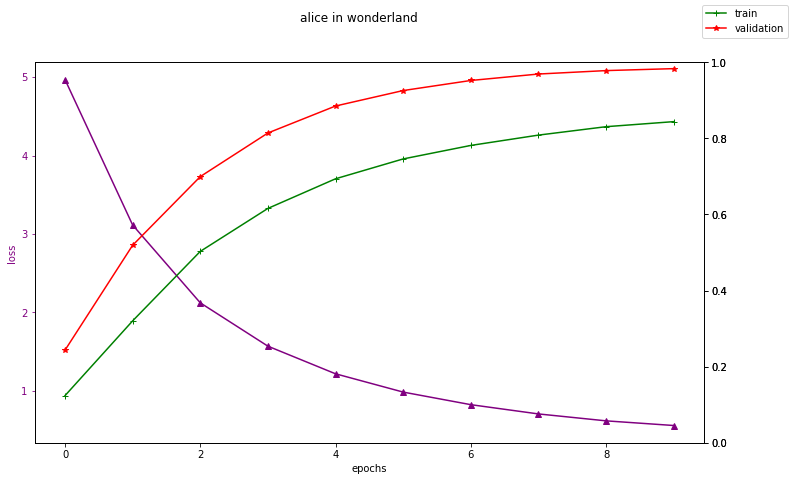

In [23]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.suptitle('alice in wonderland');
fig.legend();

In [24]:
model.save('alice.h5')

# Model predictions

***
***
***

In [39]:
sample = [ 786, 1405,  726,  748, 1071, 1436,  963,  890,  927]

In [40]:
' '.join([index_to_word[s] for s in sample])

'i down the rabbit hole alice was beginning to'

In [43]:
pred = model.predict(np.array([sample]))
pred

array([[3.2803247e-09, 3.9248893e-09, 5.2023375e-07, ..., 3.1371780e-13,
        1.1916906e-09, 7.4769631e-14]], dtype=float32)

In [44]:
pred.argmax()

934

In [51]:
top5 = pred.argsort()[0][::-1][:5]
top5

array([ 934,   46,  464,  231, 1016])

In [52]:
[index_to_word[t] for t in top5]

['know', 'put', 'make', 'grow', 'fall']